In [207]:
import pandas as pd
#from sklearn.naive_bayes import MultinomialNB

In [301]:
# Load data
data = pd.read_csv('https://otf.ca/sites/default/files/OTF-Grants_since2000.csv')

In [302]:
data = data.drop(columns=['Funding Org:Org subventionnaire', 'Country Served:Pays servis', 'Province Served:Province servis', 'Cross-catchment indicator:Indicateur interrégional', 'Co-Application:Co-demandeurs', 'Description (French/Français)', 'Grant Result:Résultat de subvention','Rescinded/Recovered:Révoqué/récupéré','Rescinded/Recovered Initiated By:Révoqué/récupéré intié par','Amount Rescinded/Recovered:Montant révoqué/récupéré', 'Last modified:Mise à jour'])
data.columns = ['fiscal_year','grant_program','geographical_area','identifier','org_name','submission_date', 'approval_date', 'amount_applied', 'amount_awarded', 'planned_duration', 'description', 'program_area', 'budget_fund', 'org_incorporation_num', 'org_charitable_reg_num', 'org_city', 'org_postcode', 'population_served', 'age_group']

In [303]:
description = pd.DataFrame(data, columns = ['description'])

In [304]:
# remove structured text and keep only free-form text
a = description['description'].str.split('programs for Ontarians by ').str[1].dropna()
b = description['description'].str.split('grant over \d+ years to ').str[1].dropna()
c = description['description'].str.split('rebuild and recover from impacts of COVID-19 by ').str[1].dropna()
d = description['description'].str.split('grant over \d+ months to ').str[1].dropna()
e = description['description'].str.split('\$\d+( \w+|[\d,]+) over \d+ months to ').str[2].dropna()
f = description['description'].str.split('\$\d+( \w+|[\d,]+) over one year to ').str[2].dropna()
g = description['description'].str.split('\$\d+( \w+|[\d,]+) over two years to ').str[2].dropna()
h = description['description'].str.split('\$\d+( \w+|[\d,]+) over three years to ').str[2].dropna()
i = description['description'].str.split('\$\d+( \w+|[\d,]+) over six months to ').str[2].dropna()
j = description['description'].str.split('This project aims to ').str[1].dropna()

In [305]:
description_clean = pd.concat([a, b, c, d, e, f, g, h, i, j], axis=0,ignore_index=False)
description_clean = description_clean.to_frame()

In [306]:
add_indices = pd.Index(range(27952)).difference(description_clean.index)
add_df = pd.DataFrame(index=add_indices, columns=description_clean.columns).fillna(description)
description_clean = pd.concat([description_clean, add_df])

In [307]:
#from sklearn.feature_extraction.text import CountVectorizer
#vectorizer = CountVectorizer(ngram_range=(1,1), min_df = 50, max_df = 0.95, stop_words='english')
#counts_sparse = vectorizer.fit_transform(description_clean['description'])
#counts = pd.DataFrame(counts_sparse.toarray(), index=description_clean.index, columns=vectorizer.get_feature_names())
#counts

In [314]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features = 300, stop_words = 'english')
counts_sparse = vectorizer.fit_transform(description_clean['description'])
counts = pd.DataFrame(counts_sparse.toarray(), index=description_clean.index, columns=vectorizer.get_feature_names())
counts = counts.drop(counts.columns[0:11], axis=1) 

In [317]:
counts.shape

(27953, 289)

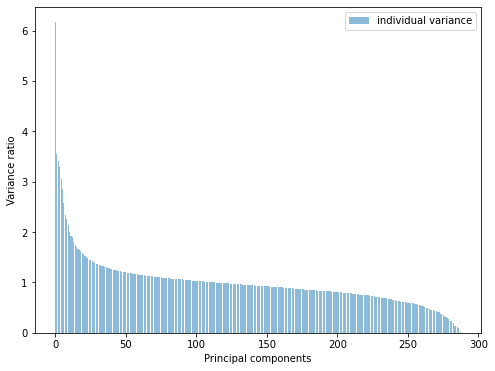

In [319]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
enconder = LabelEncoder()

for col in counts.columns:
    counts[col] = enconder.fit_transform(counts[col])
    
counts_features = counts.iloc[:,1:289]
counts_label = counts.iloc[:,0]

scaler = StandardScaler()
counts_features = scaler.fit_transform(counts_features)
    
pca = PCA()
pca.fit_transform(counts_features)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(288), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

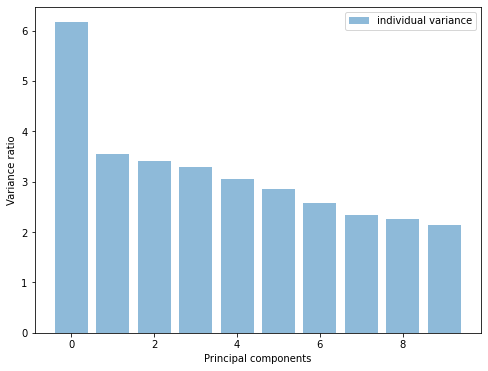

In [320]:
pca2 = PCA(n_components=10)
pca2.fit(counts_features)
counts_reduced = pca2.transform(counts_features)

pca_variance2 = pca2.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(10), pca_variance2, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()


In [247]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Text(0, 0.5, 'inertia (WSS)')

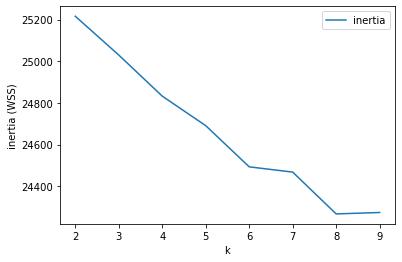

In [226]:
inertia_list = []
for k in range(2,10):
    model = KMeans(n_clusters=k)
    model.fit(counts)
    cluster_id = pd.Series(model.predict(counts))
    inertia_list.append({'k':k, 'inertia':model.inertia_})

ax = pd.DataFrame(inertia_list).set_index('k').plot.line()
ax.set_ylabel('inertia (WSS)')

In [250]:
sil_scores = []
for k in range(3,9):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(counts)
    label = clusterer.predict(counts)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(counts, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label']
best_label

# Present some summary statistics for each clusters
counts.groupby(best_label).mean()

,000,10,100,11,12,13,14,15,150,16,...,works,workshop,workshops,world,would,year,years,york,young,youth
0,0.002265,0.002307,0.000831,0.001077,0.002684,0.001470,0.001161,0.001706,0.000281,0.001551,...,0.001936,0.001712,0.009637,0.001877,0.001699,0.003558,0.002551,0.006091,0.009207,0.031296
1,0.095299,0.010388,0.012360,0.002963,0.009212,0.005032,0.005656,0.011730,0.005003,0.003791,...,0.001291,0.001615,0.005624,0.001672,0.001161,0.057561,0.068958,0.003963,0.006477,0.023384
2,0.035384,0.008720,0.008470,0.001704,0.005149,0.001324,0.001402,0.003713,0.005072,0.001901,...,0.000309,0.001650,0.004584,0.000089,0.000066,0.002110,0.000554,0.002385,0.004856,0.051842
3,0.004877,0.001763,0.002146,0.001023,0.001890,0.001261,0.001914,0.002126,0.000656,0.001271,...,0.000416,0.000467,0.001507,0.000443,0.000772,0.005455,0.002695,0.001514,0.004528,0.018179


In [181]:
#pd.DataFrame(x).to_csv('x.csv', index=True, header=False)

In [156]:
#pd.DataFrame(description).to_csv('desc.csv', index=True, header=False)

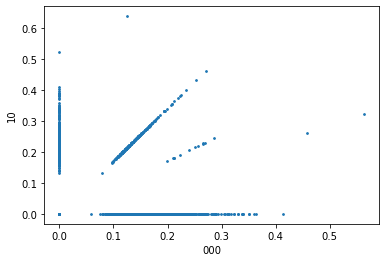

In [246]:
model = KMeans(n_clusters=6)
model.fit(counts)
assignments = pd.Series(model.predict(counts))
ax = counts.plot.scatter(0, 1, 3)

In [89]:
# Split data for classif
#training = featured.head(22360)
#testing = featured.tail(5593)
#holdout = training.groupby('grant_program', group_keys=False).apply(lambda x: x.sample(frac=0.2, random_state=3))
#training = training.drop(holdout.index)